In [42]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from cfxplorer import Focus
import tensorflow as tf

# def get_tf_session():
#     return tf.compat.v1.Session()

# Feature importances
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from alibi.explainers import Counterfactual
from alibi.utils.mapping import ohe_to_ord

In [43]:
data_proper = pd.read_csv(r"data_cleaned.csv")

# Map Mental_Health_History to numeric
data_proper["Mental_Health_History"] = data_proper["Mental_Health_History"]\
    .map({"No": 0, "Maybe": 1, "Yes": 2})

# Get 20% sample to detect feature importances
X = data_proper.loc[:, [col for col in data_proper if col != "treatment" if col != "Timestamp" if 
                        col != "Country"]]
y = data_proper.loc[:, "treatment"]
X, _, y, _ = train_test_split(X.astype(np.float64), y.astype(np.float64), train_size=0.0075, 
                              stratify=y, random_state=0)
X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)

X_train, X_test, y_train, y_test = train_test_split(X.astype(float), y.astype(float), train_size=0.7, 
                                                    stratify=y, random_state=0)

In [44]:
X_train.shape, X_test.shape

((1507, 42), (646, 42))

In [45]:
clf = RandomForestClassifier(random_state=0)

# Train the model with your data
clf.fit(X_train, y_train)  # Assuming X_train and y_train are your training features and labels

RandomForestClassifier(random_state=0)

In [46]:
import shap

explainer = shap.Explainer(clf.predict, X_test, seed=0)
shap_values = explainer(X_test)

PermutationExplainer explainer: 647it [02:46,  3.60it/s]                         


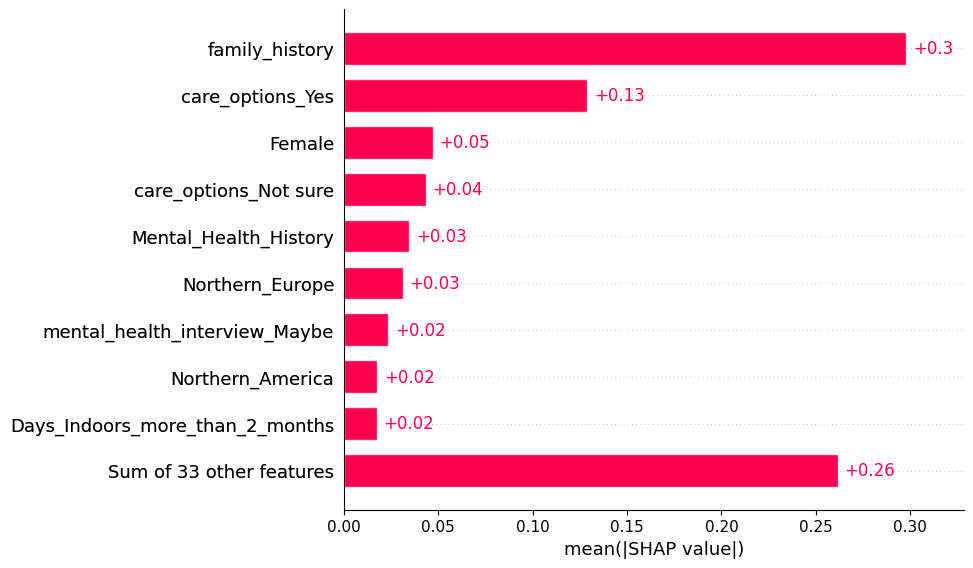

In [47]:
shap.plots.bar(shap_values)

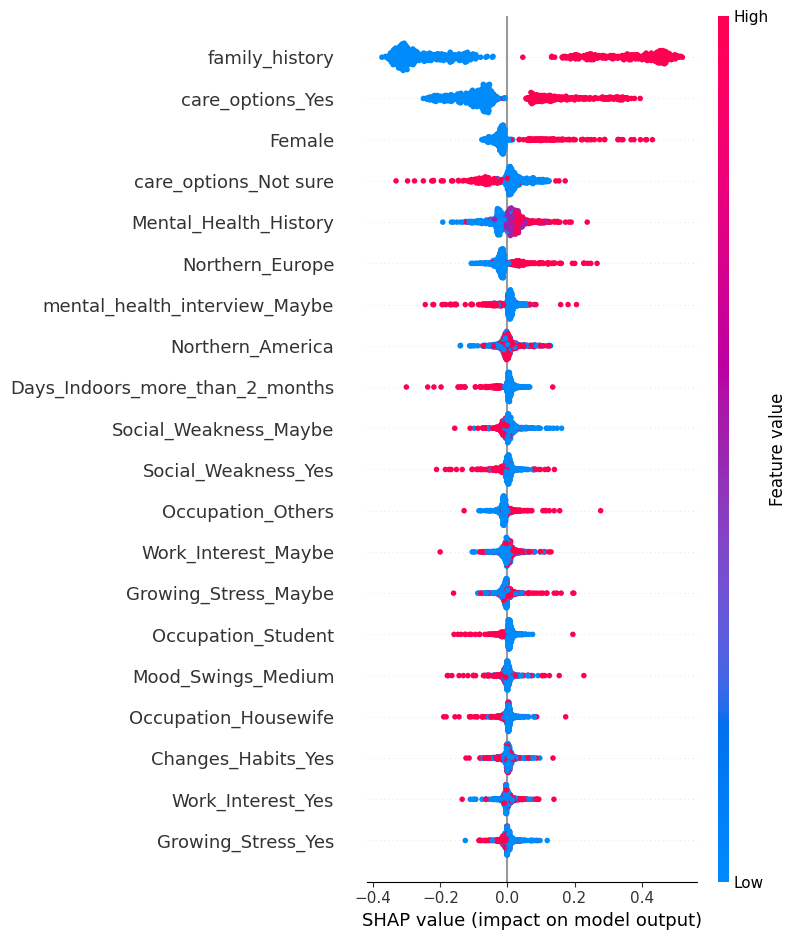

In [48]:
shap.summary_plot(shap_values)

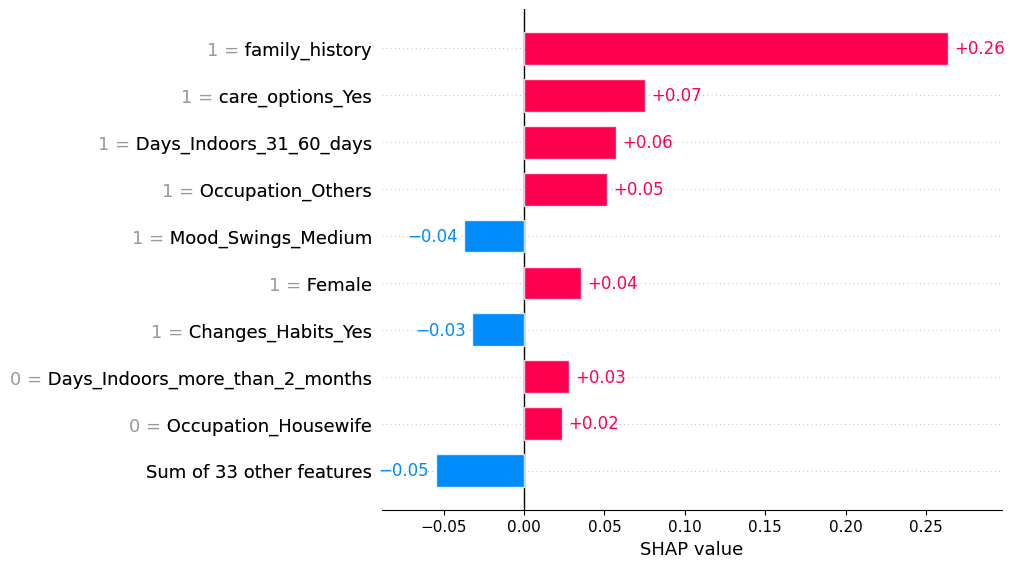

In [49]:
shap.plots.bar(shap_values[0])

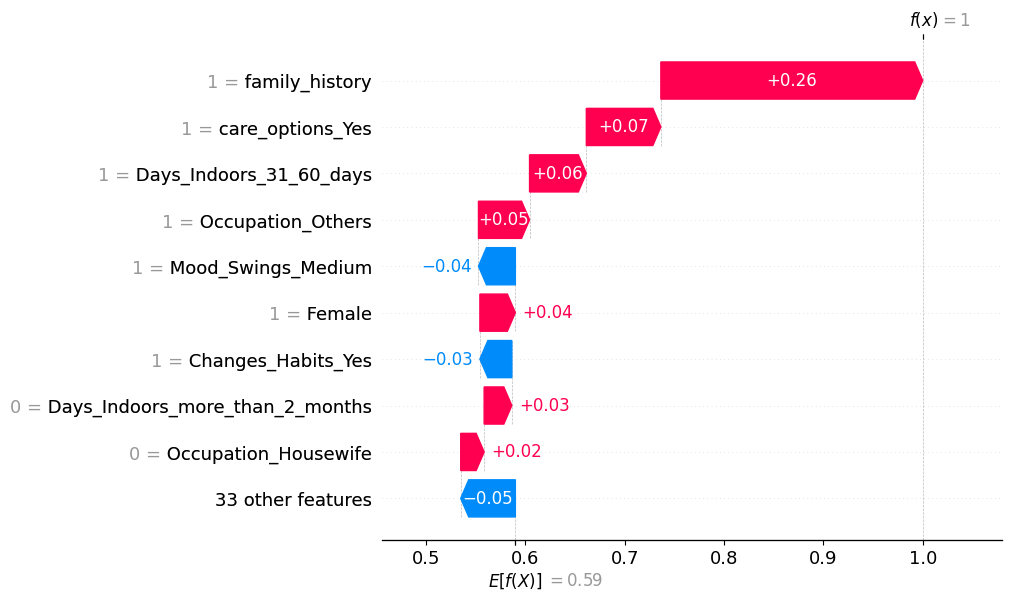

In [50]:
shap.plots.waterfall(shap_values[0])

In [51]:
x_ref = X.to_numpy()[15]

print('True label:', y[15])
print('Predicted label:', clf.predict(x_ref.reshape(1, -1))[0])
print('Predicted probas:', clf.predict_proba(x_ref.reshape(1, -1)))
print('Predicted probability for label 0:', clf.predict_proba(x_ref.reshape(1, -1))[0][0])


True label: 1.0
Predicted label: 1.0
Predicted probas: [[0.40347619 0.59652381]]
Predicted probability for label 0: 0.40347619047619043


c:\Users\BramUser\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\BramUser\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\BramUser\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [52]:
from mlxtend.evaluate import create_counterfactual
from scipy.optimize import minimize
import warnings

# Modified create_counterfactual function
def create_counterfactual_fixed(x_reference, y_desired, model, X_dataset, y_desired_proba=1., lammbda=1, 
                                random_seed=0, epsilon=1e-60, round_values=True):
    rng = np.random.RandomState(random_seed)
    x_counterfact = X_dataset[rng.randint(X_dataset.shape[0])]

    # Compute median absolute deviation and add epsilon
    mad = np.abs(np.median(X_dataset, axis=0) - x_reference) + epsilon

    def dist(x_reference, x_counterfact):
        numerator = np.abs(x_reference - x_counterfact)
        return np.sum(numerator / mad)

    y_to_be_annealed_to = np.array([y_desired_proba])

    def loss(x_counterfact, lammbda):
        y_predict = model.predict_proba(x_counterfact.reshape(1, -1))[:, y_desired]
        diff = lammbda * (y_predict - y_to_be_annealed_to) ** 2
        return diff + dist(x_reference, x_counterfact)

    res = minimize(loss, x_counterfact, args=(lammbda), method="Nelder-Mead")

    if not res["success"]:
        warnings.warn(res["message"])

    return np.round(np.abs(res.x)) if round_values else res.x


res = create_counterfactual_fixed(x_reference=x_ref, 
                            y_desired=0, 
                            model=clf, 
                            X_dataset=X.to_numpy(),
                            y_desired_proba=0.51,
                            lammbda=1, #  hyperparameter
                            random_seed=123)

c:\Users\BramUser\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\BramUser\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\BramUser\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\BramUser\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\BramUser\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does

In [53]:
res

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 3.])

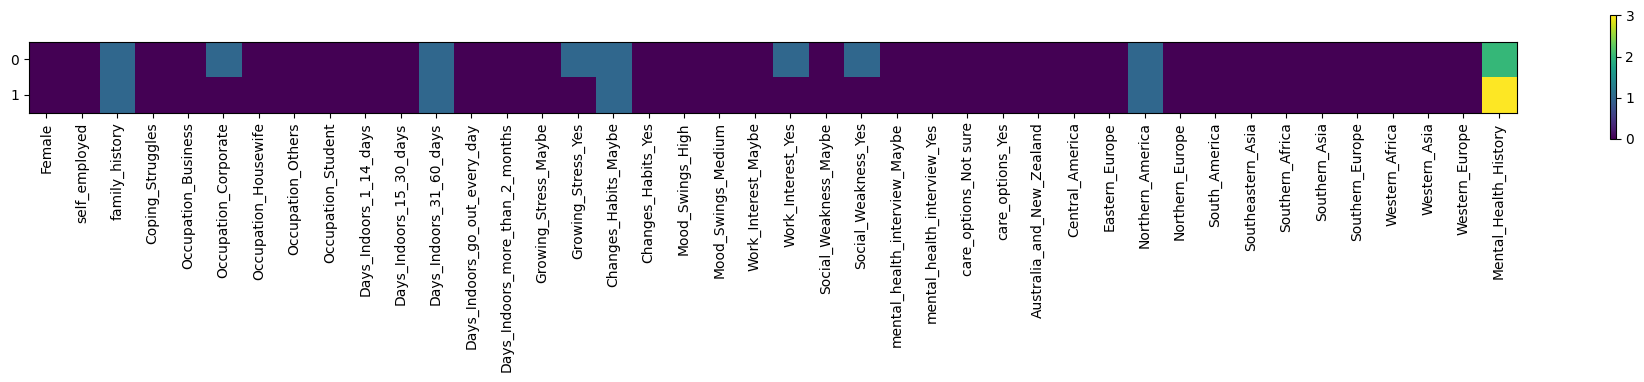

In [54]:
plt.figure(figsize=(24, 8))
mappable = plt.imshow(np.vstack([x_ref, res]))
plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.colorbar(mappable, shrink=0.2)
plt.show()

In [55]:
from mcce import mcce

In [57]:
X_train.columns

immutable_features = ["Female", "Australia_and_New_Zealand", "Central_America",
                      "Eastern_Europe", "Northern_America", "Northern_Europe",
                      "South_America", "Southeastern_Asia", "Southern_Africa", 
                      "Southern_Asia", "Southern_Europe", "Western_Africa", 
                      "Western_Asia", "Western_Europe"]

target = "treatment"

Index(['Female', 'self_employed', 'family_history', 'Coping_Struggles',
       'Occupation_Business', 'Occupation_Corporate', 'Occupation_Housewife',
       'Occupation_Others', 'Occupation_Student', 'Days_Indoors_1_14_days',
       'Days_Indoors_15_30_days', 'Days_Indoors_31_60_days',
       'Days_Indoors_go_out_every_day', 'Days_Indoors_more_than_2_months',
       'Growing_Stress_Maybe', 'Growing_Stress_Yes', 'Changes_Habits_Maybe',
       'Changes_Habits_Yes', 'Mood_Swings_High', 'Mood_Swings_Medium',
       'Work_Interest_Maybe', 'Work_Interest_Yes', 'Social_Weakness_Maybe',
       'Social_Weakness_Yes', 'mental_health_interview_Maybe',
       'mental_health_interview_Yes', 'care_options_Not sure',
       'care_options_Yes', 'Australia_and_New_Zealand', 'Central_America',
       'Eastern_Europe', 'Northern_America', 'Northern_Europe',
       'South_America', 'Southeastern_Asia', 'Southern_Africa',
       'Southern_Asia', 'Southern_Europe', 'Western_Africa', 'Western_Asia',
       '